In [1]:
# !pip install -U scikit-learn

In [2]:
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def cv(model,X,y,k):
    

# TP2 - Random Forest Model

El objetivo es crear un primer modelo básico de random forest, sin feature engineering ni hyperparameters tunning, para poder tener un primer resultado local. Luego, realizar un primer submit en kaggle y en base a eso ir mejorando el modelo 

In [65]:
train = pd.read_csv("../datasets/first-rf-model-train.csv")
test = pd.read_csv("../datasets/first-rf-model-test.csv")
train.drop(columns="Sales_Contract_No",inplace=True)
test.drop(columns="Sales_Contract_No",inplace=True)

train['Month'] = pd.to_datetime(train['Month']).dt.month
test['Month'] = pd.to_datetime(test['Month']).dt.month

In [ ]:
test.head(2)

In [66]:
target = "target"
features = list(train.columns)
features.remove(target)

split = int(0.8*len(train))


X_train, y_train = train.loc[:split,features],train.loc[:split,target]
X_test, y_test = train.loc[split:,features],train.loc[split:,target],
X_submit = test

print(X_train.shape)
print(X_test.shape)

(13558, 109)
(3390, 109)


In [69]:
num_of_trees = 25
max_depth = 6
max_features = 10
min_to_split = 15
min_to_leaf = 1


class wrapper(RandomForestClassifier):

    def predict(self,X):
        return self.predict_proba(X)

rf_model = wrapper(n_estimators=num_of_trees,\
                                     max_depth = max_depth,\
                                     max_features = max_features,\
                                     min_samples_split = min_to_split,\
                                     min_samples_leaf = min_to_leaf,\
                                     random_state=1
                                 )


In [ ]:
run = cross_val_score(rf_model,X_train,y_train,cv=1+int(len(X_train)/15),scoring= make_scorer(log_loss))
run_df = pd.Series(run)
run_df.describe()

In [ ]:
round(run_df,2).value_counts()

In [70]:
sns.kdeplot(run_df)

NameError: name 'run_df' is not defined

In [71]:
rf_model.fit(X_train,y_train)
pred = rf_model.predict_proba(X_test)
pred_df =  pd.DataFrame(pred)
display(pred_df.head())

print("Error de mi test: ",log_loss(y_test,pred_df[1].values))

,0,1
0,0.067980,0.932020
1,0.064029,0.935971
2,0.382982,0.617018
3,0.448055,0.551945
4,0.387161,0.612839


Error de mi test:  0.5531028326177121


### Evaluación del modelo
  * Promedio del Cv : 0.429001
  * Error de test :   0.55310
  * Error del submit: 0.56357 (aprox)

In [72]:
pred_df = pd.DataFrame(X_test["Opportunity_ID"])
pred_df[["Other","Target"]] = pred
pred_df.drop(columns="Other",inplace=True)
pred_df = pred_df.drop_duplicates("Opportunity_ID")
pred_df

,Opportunity_ID,Target
13557,8254,0.932020
13559,8255,0.617018
13560,8258,0.551945
13561,8259,0.612839
13562,8260,0.938001
...,...,...
16939,12799,0.283225
16940,12800,0.199636
16942,12801,0.578792
16945,12802,0.204538


In [ ]:
# Exportamos el resultado para hacer un submit

#pred_df.to_csv("../submits/rf_model1.csv", index=False)


In [73]:
from log.Logger import Logger

model_name = "RandomForest"
score = 1.5
kaggle_score = 0.30216
notas = "intento1 - set filtrado y features encodeadas"
dataset_name = "first-rf-model-train.csv"
hyperparm = {"n_estimators": num_of_trees,
              "max_depth" : max_depth,
              "max_features" : max_features,
              "min_samples_split" : min_to_split,
              "min_samples_leaf" : min_to_leaf,
              "random_state" : 1
            }

#Logger.log_model(model_name,score,kaggle_score,notas,dataset_name,hyperparm)

In [74]:
to_plot = pd.DataFrame(zip(X_train,rf_model.feature_importances_),columns=["Column","Importance"])\
            .sort_values("Importance", ascending= False)
            
print("Suma de importancias: ", to_plot["Importance"].sum())

to_plot= to_plot.nlargest(25,"Importance")
to_plot.head()

Suma de importancias:  1.0000000000000002


,Column,Importance
10,Total_Amount,0.122650
108,Bureaucratic_Code_2,0.113044
9,TRF,0.110984
1,"Pricing, Delivery_Terms_Approved",0.042262
47,Opportunity_Type_2,0.042062


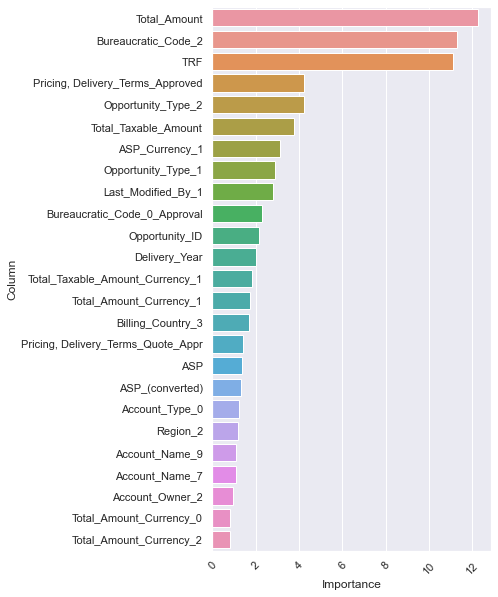

In [75]:
sns.set(rc={'figure.figsize':(5,10)})
sns.barplot(x=(to_plot["Importance"]*100),y=to_plot["Column"],orient="h")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Ejecutamos un proceso que calcule diferentes scores con diferentes valores de k
# Para evaluar la precisión de esta manera de tener un train socore
from time import process_time

data = {}
rf_model = wrapper(n_estimators=num_of_trees,\
                                     max_depth = max_depth,\
                                     max_features = max_features,\
                                     min_samples_split = min_to_split,\
                                     min_samples_leaf = min_to_leaf,\
                                     random_state=1
                                 )


for i in range(2,6000,350):
    
    
    
    t0 = process_time()
    
    run = cross_val_score(rf_model,X_train,y_train,cv=i,scoring= make_scorer(log_loss))
    
    delta = process_time()- t0
    data[i] = (run,round(delta,3))
    
    mins = round(delta/60)
    secs = round(delta - int(delta/60)*60,3)
    
    print(f"Last ran: k={i} delta={str(secs)+'s' if delta <= 60 else str(mins)+' : '+str(secs)+'s' }")
    

    

In [ ]:
re_data = [x[0] for k,x in data.items()]
idx = [ k for k in data ]

In [ ]:
re_data = []
for v,d in data.items():
    re_data.append((v,d[0].mean(),d[1]))


In [ ]:
results = pd.DataFrame(re_data)
results.index = idx
results = results.transpose()
results

In [ ]:
to_plot = ["352","1402","2452","5952"]
for col in to_plot:

    ax = sns.kdeplot(results[int(col)])

ax.legend(to_plot)
plt.show()


## Segundo modelo de random forest

Ya hicimos una prueba piloto, ahora nos dedicamos a emprolijar el set de datos. Hicimos algo de feature engineering y eliminamos un par de columnas que tenian información dada por otras.

In [ ]:
train = pd.read_csv("../datasets/second-rf-model-train.csv")
test = pd.read_csv("../datasets/second-rf-model-test.csv")
test.head(2)

target = "target"
features = list(train.columns)
features.remove("Opportunity_ID")
features.remove(target)

split = int(0.8*len(train))


X_train, y_train = train.loc[:split,features],train.loc[:split,target]
X_test, y_test = train.loc[split:,features],train.loc[split:,target],

X_submit = test.drop(columns="Opportunity_ID")
ID_submit = test.loc[:,"Opportunity_ID"]

print("Train set: ",X_train.shape, " | train Y: ",y_train.shape)
print("Test set:  ",X_test.shape, " |  test Y: ",y_test.shape)

In [ ]:
num_of_trees = 25
max_depth = 6
max_features = 10
min_to_split = 15
min_to_leaf = 1


class wrapper(RandomForestClassifier):

    def predict(self,X):
        return self.predict_proba(X)

rf_model = wrapper(n_estimators=num_of_trees,\
                                     max_depth = max_depth,\
                                     max_features = max_features,\
                                     min_samples_split = min_to_split,\
                                     min_samples_leaf = min_to_leaf,\
                                     random_state=1
                                 )

In [ ]:
run = cross_val_score(rf_model,X_train,y_train,cv=1+int(len(X_train)/15),scoring= make_scorer(log_loss))
run = pd.Series(run)
run.describe()

In [ ]:
sns.kdeplot(run)

In [ ]:
rf_model.fit(X_train,y_train)
pred = rf_model.predict_proba(X_test)
pred_df =  pd.DataFrame(pred)
display(pred_df.head(10))
print("First 5 targets",y_test.values[:10],"\n")

print("Error de mi test: ",log_loss(y_test,pred_df[1].values)) 

In [ ]:
rf_model.fit(X_train,y_train)
pred = rf_model.predict_proba(X_submit)
pred_df = pd.DataFrame(ID_submit)
pred_df[["Other","Target"]] = pred
pred_df.drop(columns="Other",inplace=True)
pred_df

In [ ]:
# Exportamos el resultado para hacer un submit

#pred_df.to_csv("../submits/rf_model2.csv", index=False)

In [ ]:
to_plot = pd.DataFrame(zip(X_train,rf_model.feature_importances_),columns=["Column","Importance"])\
            .sort_values("Importance", ascending= False)
            

sns.set(rc={'figure.figsize':(5,15)})

largest= to_plot.nlargest(30,"Importance")
sns.barplot(x=(largest["Importance"]*100),y=largest["Column"],orient="h",palette= "crest")
plt.xticks(rotation=45)
plt.show()

smallest= to_plot.nsmallest(30,"Importance")
sns.barplot(x=(smallest["Importance"]*100),y=smallest["Column"],orient="h",palette="mako")
plt.xticks(rotation=45)
plt.show()

### Evaluación del modelo
  * Promedio del Cv : 0.465989
  * Error de test :   0.50779
  * Error del submit: 0.53223 (aprox)
  
Podemos ver que los cambios en el set de datos fueron positivos, aunque no fue un gran cambio del valor del log_loss en ambos casos.
Ademas las columnas introducidas ganaron notable importancia.

Lo primero que podemos hacer es tunnear los hyperparametros, ya los valores elegido inicialmente fueron con la intención de tener un primer valor tentativo. Procedemos a hacer un tunning manual, y luego Optimización Bayeciana que nos permitirá una mejor confianza en los resultados.

## Optimización bayeciana

In [ ]:
!pip install scikit-optimize

#### Results

   * space = [ [2,200],
              [2,40],
              [2,100],
              [20,200],
              [10,100]
               ]           
       Result = [126, 40, 53, 20, 10]  fun= 0.41125

In [ ]:
from sklearn.model_selection import cross_val_score
from skopt import gp_minimize

def my_scorer(model,X,y):
    
    pred = model.predict_proba(X)
    pred = pd.DataFrame(pred)
    pred = pred[1]
    
    return log_loss(y,pred)

# Usamos los datasets definidos en el anterior modelo
def objective(params):
    
    n_estimators = params[0]
    max_depth = params[1]
    max_features = params[2]
    min_samples_split = params[3]
    min_samples_leaf = params[4]

    model = wrapper(n_estimators=n_estimators,\
                     max_depth = max_depth,\
                     max_features = max_features,\
                     min_samples_split = min_samples_split,\
                     min_samples_leaf = min_samples_leaf,\
                     random_state=1)

    # Utilizamos un cross validation con k chico para que sea más rapido
    return np.mean(cross_val_score(model,X_train,y_train,cv=10,scoring= my_scorer))


# Lista cuyo contenido es el subdominio entero que queremos utilizar para el tunning de los hyperparametros
# el orden de enlistado es el mismo del orden de desenlistado en la funcion objetivo
space = [ [50,250],
          [2,15],
          [2,80],
          [5,100],
          [2,50]
        ]

r = gp_minimize(objective,space,n_calls=50,random_state=1)

In [ ]:
r.fun

In [ ]:
r.x

In [ ]:
n_estimators = 126
max_depth = 40
max_features = 53
min_samples_split = 20
min_samples_leaf = 10

rf_model = wrapper(n_estimators=n_estimators,\
                     max_depth = max_depth,\
                     max_features = max_features,\
                     min_samples_split = min_samples_split,\
                     min_samples_leaf = min_samples_leaf,\
                     random_state=1)

In [ ]:
run = cross_val_score(rf_model,X_train,y_train,cv=1+int(len(X_train)/15),scoring= make_scorer(log_loss))
run = pd.Series(run)
sns.set(rc={'figure.figsize':(5,5)})
sns.kdeplot(run)

In [ ]:
rf_model.fit(X_train,y_train)
pred = rf_model.predict_proba(X_test)
pred_df =  pd.DataFrame(pred)
display(pred_df.head(10))
print("First 10 targets",y_test.values[:10],"\n")

print("Error de mi test: ",log_loss(y_test,pred_df[1].values)) 

In [ ]:
to_plot = pd.DataFrame(zip(X_train,rf_model.feature_importances_),columns=["Column","Importance"])\
            .sort_values("Importance", ascending= False)

sns.set(rc={'figure.figsize':(5,15)})

largest= to_plot.nlargest(30,"Importance")
sns.barplot(x=(largest["Importance"]*100),y=largest["Column"],orient="h",palette= "crest")
plt.xticks(rotation=45)
plt.show()

smallest= to_plot.nsmallest(30,"Importance")
sns.barplot(x=(smallest["Importance"]*100),y=smallest["Column"],orient="h",palette="mako")
plt.xticks(rotation=45)
plt.show()

### Evaluación del modelo optimizado
  * Promedio del Cv : 
  * Error de test :   0.47542
  * Error del submit:  

Despues de dos iteraciones de la optimización bayeciana, concluimos que hay que seguir trabajando en el set de datos para poder obtener un mejoramiento notable.

### Tercer modelo

En esta ocación, contamos con un mean encoding de Territorios, un tratado de conversiones de valores monetarios y correcciones en el armado del set de datos. Ademas utilizamos el modelo optimizado anteriormente para ver como impacta en los resultados

In [ ]:
train = pd.read_csv("../datasets/third-rf-model-train.csv")
test = pd.read_csv("../datasets/third-rf-model-test.csv")

target = "target"
features = list(train.columns)
features.remove("Opportunity_ID")
features.remove(target)

split = int(0.8*len(train))


X_train, y_train = train.loc[:split,features],train.loc[:split,target]
X_test, y_test = train.loc[split:,features],train.loc[split:,target],

X_submit = test.drop(columns="Opportunity_ID")
ID_submit = test.loc[:,"Opportunity_ID"]

print("Train set: ",X_train.shape, " | train Y: ",y_train.shape)
print("Test set:  ",X_test.shape, " |  test Y: ",y_test.shape)


In [ ]:
n_estimators = 126
max_depth = 40
max_features = 53
min_samples_split = 20
min_samples_leaf = 10

rf_model = wrapper(n_estimators=n_estimators,\
                     max_depth = max_depth,\
                     max_features = max_features,\
                     min_samples_split = min_samples_split,\
                     min_samples_leaf = min_samples_leaf,\
                     random_state=1)


In [ ]:
rf_model.fit(X_train,y_train)
pred = rf_model.predict_proba(X_test)
pred_df =  pd.DataFrame(pred)
display(pred_df.head(10))
print("First 5 targets",y_test.values[:10],"\n")

print("Error de mi test: ",log_loss(y_test,pred_df[1].values)) 

In [ ]:
rf_model.fit(X_train,y_train)
pred = rf_model.predict_proba(X_submit)
pred_df = pd.DataFrame(ID_submit)
pred_df[["Other","Target"]] = pred
pred_df.drop(columns="Other",inplace=True)
pred_df

In [ ]:
name = "rf-3-TerritoryMeanEncoding.csv"
#pred_df.to_csv("../submits/"+name,index=False)

### Evaluación del modelo 
  * Promedio del Cv : 
  * Error de test :   0.463039
  * Error del submit:  0.54179

In [37]:
def plot_importance(model,X):
    to_plot = pd.DataFrame(zip(X,model.feature_importances_),columns=["Column","Importance"])\
                .sort_values("Importance", ascending= False)


    sns.set(rc={'figure.figsize':(5,15)})

    largest= to_plot.nlargest(30,"Importance")
    sns.barplot(x=(largest["Importance"]*100),y=largest["Column"],orient="h",palette= "crest")
    plt.xticks(rotation=45)
    plt.show()

    smallest= to_plot.nsmallest(30,"Importance")
    sns.barplot(x=(smallest["Importance"]*100),y=smallest["Column"],orient="h",palette="mako")
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
train = pd.read_csv("../datasets/third-rf-model(2)-train.csv")
test = pd.read_csv("../datasets/third-rf-model(2)-test.csv")

target = "target"
features = list(train.columns)

excluded = ["target"]
for col in excluded:
    if col in features:
        features.remove(col)

split = int(0.8*len(train))


X_train, y_train = train.loc[:split,features],train.loc[:split,target]
X_test, y_test = train.loc[split:,features],train.loc[split:,target],

X_submit = test[features]
ID_submit = test.loc[:,"Opportunity_ID"]

print("Train set: ",X_train.shape, " | train Y: ",y_train.shape)
print("Test set:  ",X_test.shape, " |  test Y: ",y_test.shape)


In [ ]:
n_estimators = 126
max_depth = 40
max_features = 53
min_samples_split = 20
min_samples_leaf = 10

rf_model = wrapper(n_estimators=n_estimators,\
                     max_depth = max_depth,\
                     max_features = max_features,\
                     min_samples_split = min_samples_split,\
                     min_samples_leaf = min_samples_leaf,\
                     random_state=1)


In [ ]:
rf_model.fit(X_train,y_train)
pred = rf_model.predict_proba(X_test)
pred_df =  pd.DataFrame(pred)
display(pred_df.head(10))
print("First 5 targets",y_test.values[:10],"\n")

print("Error de mi test: ",log_loss(y_test,pred_df[1].values)) 

In [ ]:
rf_model.fit(X_train,y_train)
pred = rf_model.predict_proba(X_submit)
pred_df = pd.DataFrame(ID_submit)
pred_df[["Other","Target"]] = pred
pred_df.drop(columns="Other",inplace=True)
pred_df

In [ ]:
name = "rf-3-TerritoryMeanEncoding2.csv"
#pred_df.to_csv("../submits/"+name,index=False)

### Evaluación del modelo optimizado
  * Promedio del Cv : 
  * Error de test :   0.463039
  * Error del submit:  0.54179

In [ ]:
to_plot = pd.DataFrame(zip(X_train,rf_model.feature_importances_),columns=["Column","Importance"])\
            .sort_values("Importance", ascending= False)
            

sns.set(rc={'figure.figsize':(5,30)})

largest= to_plot.nlargest(84,"Importance")
sns.barplot(x=(largest["Importance"]*100),y=largest["Column"],orient="h",palette= "crest")
plt.xticks(rotation=45)
plt.show()


# Evaluando modelo RF - FeatureEngineering Sets

Optimización bayeciana = [200, 13, 21, 5, 2]   ->   0.42956752090696926
                         [325, 13, 19, 5, 2]   ->   0.42694991242169894
                         [250, 14, 1, 17, 5, 2] ->  0.4252669681029276

In [37]:
train = pd.read_csv("../datasets/featureEngineering-train.csv")
test = pd.read_csv("../datasets/featureEngineering-test.csv")

target = "target"
features = list(train.columns)
features.remove("Opportunity_ID")
features.remove("Sales_Contract_No")
features.remove(target)

split = int(0.8*len(train))

X_train, y_train = train.loc[:split,features],train.loc[:split,target]
X_test, y_test = train.loc[split:,features],train.loc[split:,target]

X_submit = test.loc[:,features]
ID_submit = test.loc[:,"Opportunity_ID"]

print("Train set: ",X_train.shape, " | train y: ",y_train.shape)
print("Test set:  ",X_test.shape, " |  test y: ",y_test.shape)
print("Submit set:",X_submit.shape)

Train set:  (7873, 89)  | train y:  (7873,)
Test set:   (1969, 89)  |  test y:  (1969,)
Submit set: (1567, 89)


In [7]:
class wrapper(RandomForestClassifier):
    def predict(self,X):
        return self.predict_proba(X)

In [57]:
from sklearn.model_selection import cross_val_score
from skopt import gp_minimize

def my_scorer(model,X,y):
    
    pred = model.predict_proba(X)
    pred = pd.DataFrame(pred)
    pred = pred[1]
    score = log_loss(y,pred)
    #print("My Scorer: ", score)
    
    return score

criterions =["gini","entropy"]
opt_features = []
for f in features:
    to_drop = False
    for e in excluded:
        if not f.find(e) is -1:
            to_drop = True
            break
    if not to_drop:
        opt_features.append(f)
opt_set = X_train[opt_features]
opt_y = y_train

# Usamos los datasets definidos en el anterior modelo
def objective(params):
    
    n_estimators = params[0]
    max_depth = params[1]
    criterion = criterions[params[2]]
    max_features = params[3]
    min_samples_split = params[4]
    min_samples_leaf = params[5]

    model = wrapper( n_estimators=n_estimators,\
                     max_depth = max_depth,\
                     criterion=criterion,\
                     max_features = max_features,\
                     min_samples_split = min_samples_split,\
                     min_samples_leaf = min_samples_leaf,\
                     random_state=1)
    
    score = np.mean(cross_val_score(model,opt_set,opt_y,cv=5,scoring= my_scorer))
    print("Objetive score :", score)
    # Utilizamos un cross validation con k chico para que sea más rapido
    return score


# Lista cuyo contenido es el subdominio entero que queremos utilizar para el tunning de los hyperparametros
# el orden de enlistado es el mismo del orden de desenlistado en la funcion objetivo
space = [ [100,250],
          [5,14],
          [0,1],
          [15,25],
          [5,10],
          [2,5]
        ]

r = gp_minimize(objective,space,n_calls=100,random_state=1)

Objetive score : 0.43019293214478604
Objetive score : 0.4298648271676894
Objetive score : 0.44175210445297813
Objetive score : 0.4288934043688709
Objetive score : 0.426800711637246
Objetive score : 0.43362580686067387
Objetive score : 0.4341215188007518
Objetive score : 0.4446508987671053
Objetive score : 0.4329746483325829
Objetive score : 0.43206566743435165
Objetive score : 0.4263912949416305
Objetive score : 0.4263170655827236
Objetive score : 0.432262780502371
Objetive score : 0.43126920128179547
Objetive score : 0.4686417921889576
Objetive score : 0.42744323014724267
Objetive score : 0.4332414793333914
Objetive score : 0.4252669681029276
Objetive score : 0.45964369037650005
Objetive score : 0.42967406237085026
Objetive score : 0.426288272517545
Objetive score : 0.43367545257523954
Objetive score : 0.4312774555446358
Objetive score : 0.425781919285719
Objetive score : 0.433175089622051
Objetive score : 0.4327168169989
Objetive score : 0.4295979306254017
Objetive score : 0.42896008

/home/tomas/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Objetive score : 0.4266916738160629
Objetive score : 0.4256035122571963
Objetive score : 0.43130751840041165
Objetive score : 0.4299704137656323
Objetive score : 0.4358164112884273
Objetive score : 0.4283119364164899
Objetive score : 0.42948924160090896
Objetive score : 0.4262998733771469
Objetive score : 0.43112503481172243
Objetive score : 0.4373581955515605
Objetive score : 0.4343087918957399
Objetive score : 0.4324495173620705
Objetive score : 0.43141708103762744
Objetive score : 0.4447024483355104
Objetive score : 0.4379843056445063
Objetive score : 0.426288272517545
Objetive score : 0.4317059465693548
Objetive score : 0.4628857089726094
Objetive score : 0.426012314318159


/home/tomas/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Objetive score : 0.426012314318159
Objetive score : 0.431306968712022
Objetive score : 0.43086282989468827
Objetive score : 0.4329172524951561


/home/tomas/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Objetive score : 0.426012314318159
Objetive score : 0.42842659587264575
Objetive score : 0.4323288532976366
Objetive score : 0.43160360820178345
Objetive score : 0.4326513803817817
Objetive score : 0.4269705084590775


/home/tomas/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Objetive score : 0.4266916738160629
Objetive score : 0.4268363244105132
Objetive score : 0.4315272086396592
Objetive score : 0.4275987336825188
Objetive score : 0.42577279108777033
Objetive score : 0.429506389092048


/home/tomas/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Objetive score : 0.42577279108777033


/home/tomas/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Objetive score : 0.42577279108777033


/home/tomas/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Objetive score : 0.426012314318159
Objetive score : 0.42801577199476604
Objetive score : 0.4287220750126039
Objetive score : 0.4322773694450396


/home/tomas/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Objetive score : 0.426012314318159
Objetive score : 0.42677365239169995
Objetive score : 0.43351752004245075
Objetive score : 0.42783129389157565
Objetive score : 0.42672953267975283
Objetive score : 0.43656905868495777


/home/tomas/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Objetive score : 0.426012314318159


/home/tomas/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Objetive score : 0.426012314318159
Objetive score : 0.4300408517977
Objetive score : 0.4309036865756668
Objetive score : 0.4311760270185999
Objetive score : 0.42675212600329504
Objetive score : 0.42536027839879764
Objetive score : 0.431729445096802


/home/tomas/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Objetive score : 0.42536027839879764


/home/tomas/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Objetive score : 0.42536027839879764


/home/tomas/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Objetive score : 0.42536027839879764
Objetive score : 0.43110493680102574
Objetive score : 0.4277988334909805
Objetive score : 0.4297869720207994
Objetive score : 0.4255659265224008
Objetive score : 0.4300407546521023
Objetive score : 0.4377485423054626
Objetive score : 0.4300326480411691
Objetive score : 0.42805224425701205
Objetive score : 0.43032226940755686
Objetive score : 0.4332414575095934


In [58]:
r.x

[250, 14, 1, 17, 5, 2]

In [59]:
r.fun

0.4252669681029276

In [61]:
n_estimators = 250
criterion = "entropy"
max_depth = 14
max_features = 17
min_samples_split = 5
min_samples_leaf = 2

model = wrapper( n_estimators=n_estimators,\
                 criterion=criterion,\
                 max_depth = max_depth,\
                 max_features = max_features,\
                 min_samples_split = min_samples_split,\
                 min_samples_leaf = min_samples_leaf,\
                 random_state=1)

In [63]:
model.fit(X_train,y_train)
pred = model.predict_proba(X_test)
pred_df =  pd.DataFrame(pred)
display(pred_df.head(10))
print("First 5 targets",y_test.values[:10],"\n")

print("Error de mi test: ",log_loss(y_test,pred_df[1].values))

,0,1
0,0.067482,0.932518
1,0.467988,0.532012
2,0.191940,0.808060
3,0.810446,0.189554
4,0.231626,0.768374
5,0.028285,0.971715
6,0.815035,0.184965
7,0.008969,0.991031
8,0.013014,0.986986
9,0.013034,0.986966


First 5 targets [1 1 1 0 1 1 0 1 1 1] 

Error de mi test:  0.4029873661811332


In [64]:
model.fit(train[features+["Sales_Contract_No"]],train[target])
pred = model.predict_proba(test[features+["Sales_Contract_No"]])
y_true = pd.DataFrame(pred,columns=["Other","Target"])
y_true = round(y_true["Target"])
y_true

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
1562    1.0
1563    1.0
1564    1.0
1565    1.0
1566    1.0
Name: Target, Length: 1567, dtype: float64

In [65]:
model.fit(train[features],train[target])
pred = model.predict_proba(X_submit)
pred_df = pd.DataFrame(pred,columns=["Other","Target"])
pred_df["Opportunity_ID"] = ID_submit
pred_df.drop(columns="Other",inplace=True)
pred_df = pred_df[["Opportunity_ID","Target"]]
pred_df

,Opportunity_ID,Target
0,10689,0.662309
1,10690,0.412094
2,10691,0.557409
3,10692,0.473250
4,10693,0.942201
...,...,...
1562,12364,0.920403
1563,12365,0.290410
1564,12366,0.266657
1565,12367,0.505509


In [66]:
print("Error submit local: ",log_loss(y_true,pred_df["Target"].values))

Error submit local:  0.6668086693176823


In [111]:
name = "rf-5-featureEngineering.csv"
#pred_df.to_csv("../submits/"+name,index=False)

* Con estrategia GINI: error de test 0.42
                       error de submit local 0.69
                       erro de submit 0.485
 
 
* Con estrategia Entropy: error de test 0.402
                          error de submit local 0.668
                          error de submit 0.47768                       
                       

In [87]:
def plot_importance(model,X):
    to_plot = pd.DataFrame(zip(X,model.feature_importances_),columns=["Column","Importance"])\
                .sort_values("Importance", ascending= False)

    sns.set(rc={'figure.figsize':(5,10)})

    largest= to_plot.sort_values("Importance",ascending=False).nlargest(20,"Importance")
    sns.barplot(x=(largest["Importance"]*100),y=largest["Column"],orient="h",palette= "crest")
    plt.xticks(rotation=45)
    plt.title("Importance of features on RF-Model")
    plt.show()

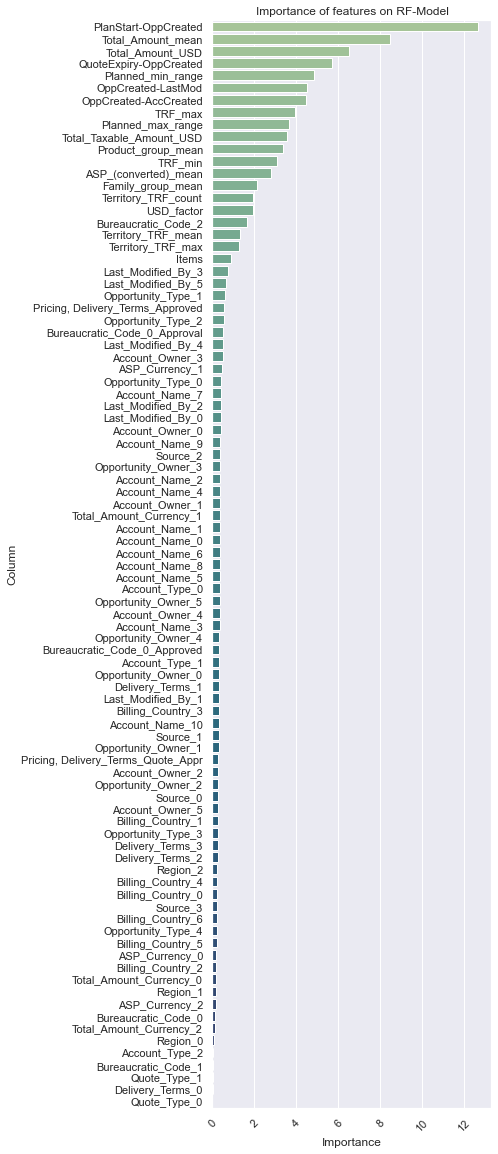

In [71]:
#plot_importance(model,X_train)

### Modelo entrenado con reducción de features

Debido a que grandes ajustes en el set, generan una muy poca variación en el score, lo que haremos a continuación reducir el numero de features que son menos importantes según este modelo. Suponemos que posiblemente las numerosas columnas poco relevantes puedan estar generendo un ruido en los datos. 

Las features descartadas son:

    * `Quote_Type_x` : ambas columnas relacionadas a su encoding, estan en el top 3
    * `Region_x`: Las tres columnas relacionadas a su encoding, estan en el top 20
    * `Total_Amount_Currency_x`: 2/3 de las columnas relacionadas a su encoding, estan en el top 12 
    * `Billing_country_x`: 6/6 de las columnas relacionadas en su encoding, están en el top 23
    * `ASP_Currency_x:

 

In [20]:
excluded = ["Quote_Type",
            "Region",
            "Billing_Country",
            "Total_Amount_Currency",
            "Opportunity_Type",
           "ASP_Currency"
            ]

In [80]:
train = pd.read_csv("../datasets/featureEngineering-train.csv")
test = pd.read_csv("../datasets/featureEngineering-test.csv")

target = "target"
features = list(train.columns)
features.remove("Opportunity_ID")
features.remove("Sales_Contract_No")
features.remove(target)

filtered = list(features)
for f in features:
    to_drop = False
    for e in excluded:
        if not f.find(e) is -1:
            to_drop = True
            break
    if to_drop:
        filtered.remove(f)

features = filtered

split = int(0.8*len(train))

X_train, y_train = train.loc[:split,features],train.loc[:split,target]
X_test, y_test = train.loc[split:,features],train.loc[split:,target]

X_submit = test.loc[:,features]
ID_submit = test.loc[:,"Opportunity_ID"]

print("Train set: ",X_train.shape, " | train y: ",y_train.shape)
print("Test set:  ",X_test.shape, " |  test y: ",y_test.shape)
print("Submit set:",X_submit.shape)




Train set:  (7873, 66)  | train y:  (7873,)
Test set:   (1969, 66)  |  test y:  (1969,)
Submit set: (1567, 66)


In [81]:
n_estimators = 250
criterion = "entropy"
max_depth = 14
max_features = 17
min_samples_split = 5
min_samples_leaf = 2

model = wrapper( n_estimators=n_estimators,\
                 criterion=criterion,\
                 max_depth = max_depth,\
                 max_features = max_features,\
                 min_samples_split = min_samples_split,\
                 min_samples_leaf = min_samples_leaf,\
                 random_state=1)

In [82]:
model.fit(X_train,y_train)
pred = model.predict_proba(X_test)
pred_df =  pd.DataFrame(pred)
display(pred_df.head(10))
print("First 5 targets",y_test.values[:10],"\n")

print("Error de mi test: ",log_loss(y_test,pred_df[1].values))

,0,1
0,0.059337,0.940663
1,0.416923,0.583077
2,0.197841,0.802159
3,0.832568,0.167432
4,0.259742,0.740258
5,0.030734,0.969266
6,0.842465,0.157535
7,0.007654,0.992346
8,0.008654,0.991346
9,0.004654,0.995346


First 5 targets [1 1 1 0 1 1 0 1 1 1] 

Error de mi test:  0.40489897877973025


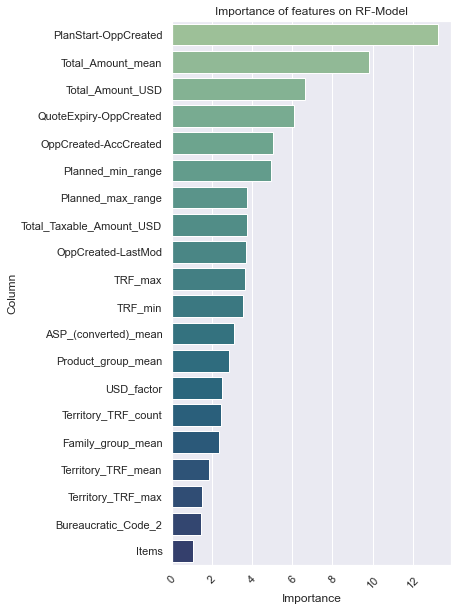

In [88]:
plot_importance(model,X_train)

In [43]:
from sklearn import tree

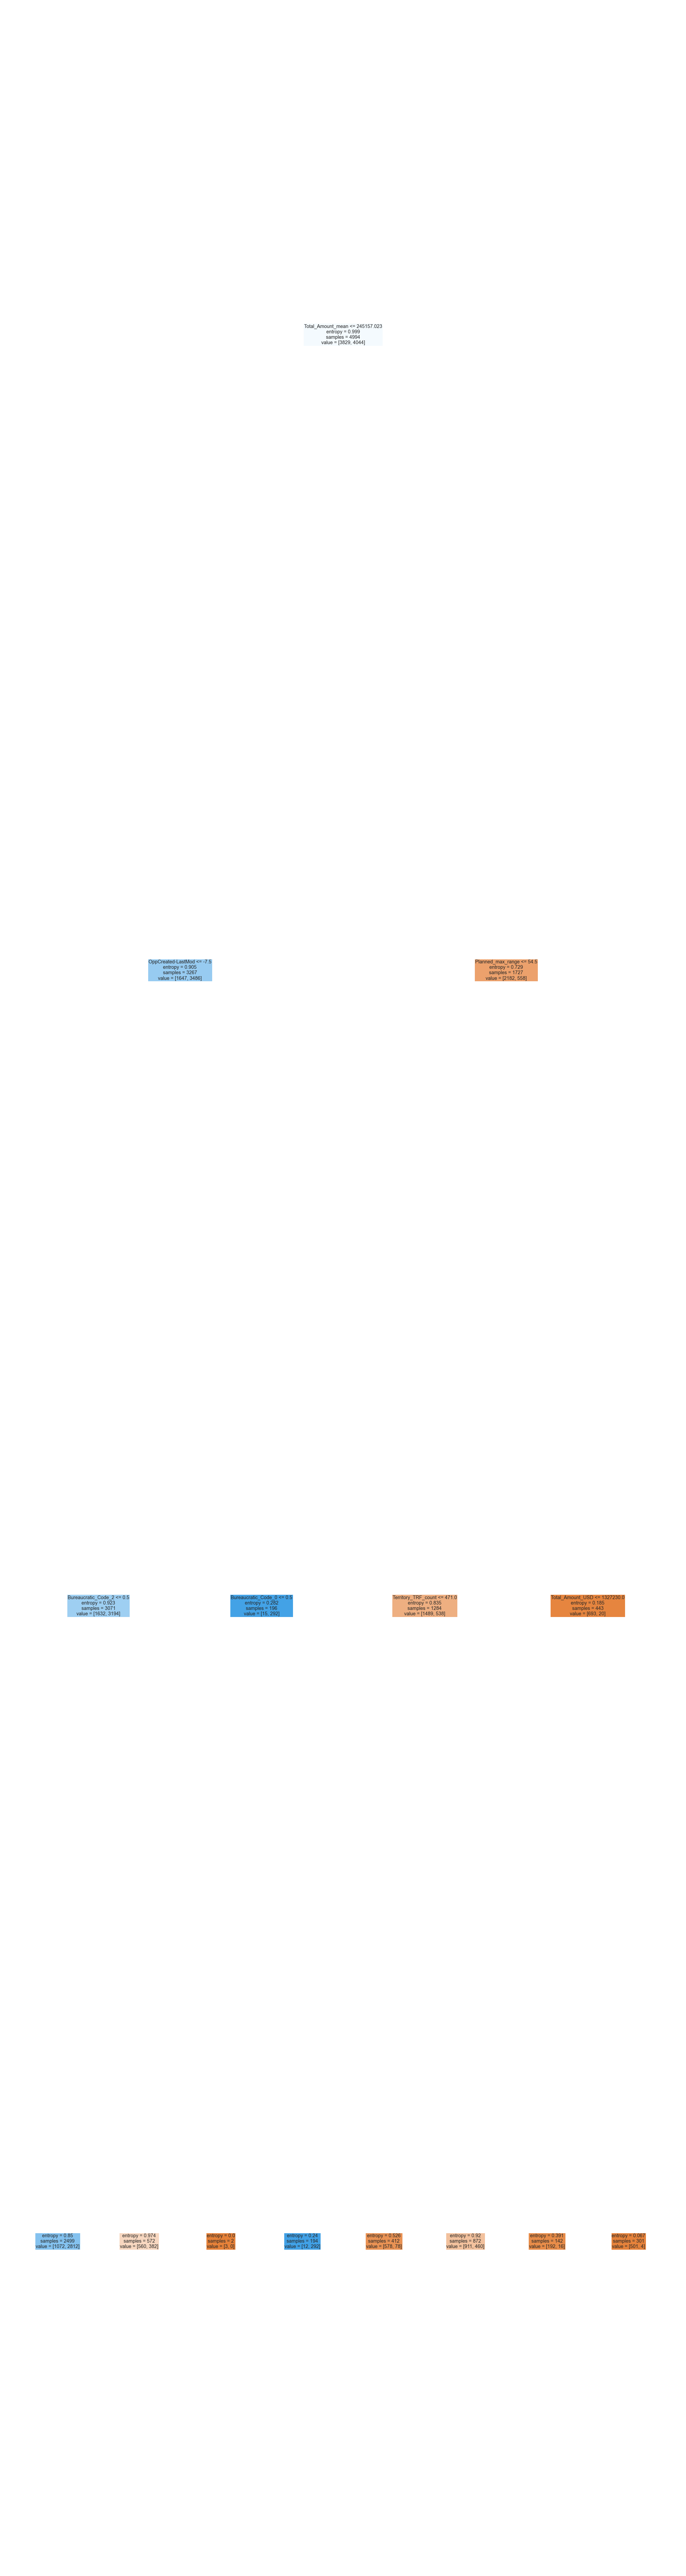

In [63]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (2,2), dpi=400)
tree.plot_tree(model.estimators_[0],
               feature_names = X_train.columns,
               filled = True);